In [ ]:
import numpy as np
import copy
import time as time
import matplotlib.pyplot as plt
#jak zrobić ciąg X unikalnych bitów?
  #1.Zamienić int o X bitach na bin -> problem -> duże wartości
  #2.Losować bity i łączyć w tablicę
  #Mogą wystąpić powtórki -> trzeba się pozbyć?
def chromosome_func_DKP(pop, n):
    bit_combinations = np.random.randint(2, size=(pop, n))
    return bit_combinations

def fitness_func_hard(chromosized_pop, v, c, C):
    eval_arr = np.zeros((len(chromosized_pop), 2), dtype=object)

    for idx, chromosome in enumerate(chromosized_pop):
        eval_arr[idx, 0] = chromosome
        weights = np.where(chromosome, c, 0)
        weight_sum = np.sum(weights)
        if(weight_sum <= C):
            values = np.where(chromosome, v, 0)
            eval_arr[idx, 1] = np.sum(values)

    eval_arr[:, 1] = eval_arr[:, 1].astype(np.int32)
    return eval_arr

def fitness_func_soft(chromosized_pop, v, c, C):
    eval_arr = np.zeros((len(chromosized_pop), 2), dtype=object)

    for idx, chromosome in enumerate(chromosized_pop):
        eval_arr[idx, 0] = chromosome
        weights = np.where(chromosome, c, 0)
        weight_sum = np.sum(weights)

        values = np.where(chromosome, v, 0)
        eval_arr[idx, 1] = np.sum(values)

        if(weight_sum > C):
            penalty = np.clip(np.power((weight_sum - C), 1.2), a_min=0, a_max=eval_arr[idx, 1]) #kara do wartości w postaci przekroczona_waga^1.2
            eval_arr[idx, 1] = eval_arr[idx, 1] - penalty

    eval_arr[:, 1] = eval_arr[:, 1].astype(np.int32)
    return eval_arr

def roulette_select(eval_arr, n_samples):
    denom = np.sum(eval_arr[:, 1])
    prob_arr = np.array(eval_arr[:, 1]/denom, dtype=np.float32)
    selected_indices = np.random.choice(len(eval_arr), size=n_samples, p=prob_arr)
    selected_chromosomes = eval_arr[selected_indices]

    return selected_chromosomes, prob_arr, 1

def ranking_select(eval_arr, n_samples):
    eval_sorted = eval_arr[eval_arr[:, 1].argsort()]

    rank_arr = np.array([i for i in range(1, len(eval_arr) + 1)])
    prob_arr = np.array((2*rank_arr)/(len(eval_arr)*(len(eval_arr) + 1)))
    selected_indices = np.random.choice(len(eval_arr), size=n_samples, p=prob_arr)
    selected_chromosomes = eval_sorted[selected_indices]
    return selected_chromosomes, prob_arr, eval_sorted


def one_point_cross(selected_chromosomes, crossover_prob=0.9):
    length = len(selected_chromosomes)
    children = np.zeros((length, 1), dtype=object)
    child_id = 0

    while child_id < length:
        #funkcja się tutaj czasami zawiesza
        parents = np.random.choice(selected_chromosomes[:, 0], size=2, replace=False)
        are_selected = np.random.rand() < crossover_prob

        if are_selected and not np.array_equal(parents[0], parents[1]): #ten warunek może być zbyteczny, ale lepiej żeby rodzic nie miał dziecka ze sobą

            cross_point = np.random.choice(len(parents[0]), size=1)

            cross_point = cross_point[0]
            chrom_A = parents[0][cross_point:]
            chrom_B = parents[1][cross_point:]

            #ta linijka naprawia problemy z krzyżowaniem.
            #dla dtype=object kopie są defaultowo shallow więc są kopiowane referencje.
            new_parents = copy.deepcopy(parents)

            new_parents[0][cross_point:] = chrom_B
            new_parents[1][cross_point:] = chrom_A

            #print(np.array_equal(new_parents[0], parents[0]))
            #print(np.array_equal(new_parents[1], parents[1]))
            children[child_id, 0] = new_parents[0]
            child_id+=1

            if child_id < length:
                children[child_id, 0] = new_parents[1]
                child_id+=1

    return children

def shuffle_segments(a, b, segment_ind):
    segment_ind = np.sort(segment_ind)

    a_new = copy.deepcopy(a)
    b_new = copy.deepcopy(b)

    start_ind = 0

    for size in segment_ind:
        end_index = min(start_ind + size, len(a))
        swap = np.random.rand() < 0.5

        if swap:
            a_new[start_ind:end_index] = b[start_ind:end_index]
            b_new[start_ind:end_index] = a[start_ind:end_index]

        start_index = end_index

    return a_new, b_new

def two_point_cross(selected_chromosomes, crossover_prob=0.9):
    length = len(selected_chromosomes)
    children = np.zeros((length, 1), dtype=object)
    child_id = 0

    while child_id < length:
        #funkcja się tutaj czasami zawiesza
        parents = np.random.choice(selected_chromosomes[:, 0], size=2, replace=False)
        are_selected = np.random.rand() < crossover_prob

        if are_selected and not np.array_equal(parents[0], parents[1]): #ten warunek może być zbyteczny, ale lepiej żeby rodzic nie miał dziecka ze sobą

            cross_points = np.random.choice(len(parents[0]), size=2)

            new_A, new_B = shuffle_segments(parents[0], parents[1], cross_points)

            #print(np.array_equal(new_parents[0], parents[0]))
            #print(np.array_equal(new_parents[1], parents[1]))
            children[child_id, 0] = new_A
            child_id+=1

            if child_id < length:
                children[child_id, 0] = new_B
                child_id+=1

    return children

def mutation(chromosomes, mutation_prob=0.001):
    for i, chromosome in enumerate(chromosomes):
        #print("Przed mutacją:", chromosome)
        for j in range(len(chromosome)):
            mutate = np.random.rand() < mutation_prob
            if mutate:
                chromosome[j] = 1 - chromosome[j]
        #print("Po mutacji:", chromosome)

    return chromosomes

In [ ]:
#warunek stopu to przejście przez określoną liczbę iteracji
#osobnik "pożądany" to taki maksymalizujący wartość i nieprzekraczający wagi
#każdy osobnik to zestaw bitów, który mówi o tym czy przedmiot i (i to numer przedmiotu) znajduje się w plecaku
class GeneticAlgorithm():
    def __init__(self):
        self.chromosome_func = None
        self.fitness_func = None
        self.selection_func = None
        self.crossover_func = None
        self.mutation_func = None
        self.iters = None
        self.history = None
        self.historyStats = None
        self.score = None
        self.trueSolution = None
    def generateApproximateSolution(self, n, v, c, C, pop, chromosome_func, fitness_func, selection_func, crossover_func, mutation_func, iters=100, history=True, trueSolution=None):
        self.chromosome_func = chromosome_func
        self.fitness_func = fitness_func
        self.selection_func = selection_func
        self.crossover_func = crossover_func
        self.mutation_func = mutation_func
        self.iters = iters
        self.history = history
        self.historyStats = np.zeros((iters, 1))
        self.score = 0
        self.trueSolution = trueSolution
        #0.funkcja do chromosomowania populacji
        chromosized_pop = self.chromosome_func(pop, n)
        #print("tablica chromosomów wstępna: ", chromosized_pop, type(chromosized_pop))
        curr_iters = 0
        while curr_iters < iters:
          #1.fitness function
              #print(curr_iters)
              eval_arr = self.fitness_func(chromosized_pop, v, c, C)
              if history:
                  self.historyStats[curr_iters] = np.sum(eval_arr[:, 1])/len(eval_arr)
              #print("tablica ewaluacji: ", eval_arr)
          #2.selection function
              select_chrom, _, _ = self.selection_func(eval_arr, pop)
              #print("tablica wybranych chromosomów: ", select_chrom)
          #3.crossover function
              crossover_chrom = self.crossover_func(select_chrom)
              #print("tablica po krzyżowaniu: ", crossover_chrom)
          #4.mutation function
              mutated_chrom = self.mutation_func(crossover_chrom)
              #print("tablica po mutacji: ", mutated_chrom, type(mutated_chrom))
          #5.przypisanie do kolejnej iteracji
              chromosized_pop = np.array([row[0] for row in mutated_chrom])
              #print("konwersja z dtype object: ", chromosized_pop, type(chromosized_pop))
              curr_iters+=1

        if history and solution is not None:
            percent_match = np.mean(self.trueSolution==chromosized_pop, axis=1)
            self.score = np.sum(percent_match)/len(chromosized_pop)

        return chromosized_pop, self.historyStats, self.score

In [ ]:
def random_knapsack_problem(n=100, scale=10**5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    items = np.ceil(scale * np.random.rand(n, 2)).astype("int32")
    v = items[:, 0]
    c = items[:, 1]
    C = int(np.ceil(0.5 * 0.5 * n * scale))
    return v, c, C

def knapsack_problem_dp_solve(v, c, C):
    n = v.size
    a = np.zeros((C + 1, n), dtype="int32") # a[i, j] = best pack of knapsack with capacity i using objects from set {0, ..., j - 1}
    b = np.empty((C + 1, n), dtype="object") # back pointers
    for j in range(n):
        b[0, j] = (0, 0)
    for i in range(1, C + 1):
        if c[0] <= i:
            a[i, 0] = v[0]
            b[i, 0] = (int(i - c[0]), 0)
        else:
            b[i, 0] = (i, -1)
        for j in range(1, n):
            i_prev = int(i - c[j])
            if c[j] > i:
                a[i, j] = a[i, j - 1]
                b[i, j] = (i, j - 1)
            elif a[i, j - 1] >= a[i_prev, j - 1] + v[j]: # użyciem przedmiotu. porównujemy
                a[i, j] = a[i, j - 1]
                b[i, j] = (i, j - 1)
            else:
                a[i, j] = a[i_prev, j - 1] + v[j] # jeśli przedmiot dał lepszy wynik
                b[i, j] = (i_prev, j - 1)
    solution = np.zeros(n, dtype="int8")
    i = C
    j = n - 1
    while i > 0 and j >= 0:
        if b[i, j][0] < i:
            solution[j] = 1
        i, j = b[i, j]
    best_pack_value = a[C, n - 1]
    return best_pack_value, solution

if __name__ == '__main__':
    n = 100
    scale = 2000
    history = True
    seed_problem = 5
    v, c, C = random_knapsack_problem(n=n, scale=scale, seed=seed_problem)
    print("RANDOM KNAPSACK PROBLEM:")
    print(f"v: {v}")
    print(f"c: {c}")
    print(f"C: {C}")

    print("SOLVING VIA DYNAMIC PROGRAMMING...")
    t1 = time.time()
    best_pack_value, solution = knapsack_problem_dp_solve(v, c, C)
    t2 = time.time()
    print("SOLVING VIA DYNAMIC PROGRAMMING DONE IN: " + str(t2 - t1) + " s.")
    print("BEST PACK VALUE: " + str(best_pack_value))
    print("SOLUTION: " + str(solution))
    print("PACK VALUE CHECK: " + str(solution.dot(v)))
    print("PACK CAPACITY CHECK: " + str(solution.dot(c)))

RANDOM KNAPSACK PROBLEM:
v: [ 444  414  977 1532  594  162  883 1760  829 1258 1200  570  656  332
 1921   49 1400   46    4 1280  519 1741    5 1963 1628 1542   59  223
 1930 1634 1271 1854 1650  723 1093  103  731 1591 1278 1167 1888 1688
  202 1021  744 1720  957 1030 1601 1146 1971  108  905  665 1843  816
  661 1054 1786 1540 1421 1535  748  480  728  121 1627  127  171  341
 1630 1179  120 1142 1652 1974 1162 1305   63  730  919 1266 1923  994
 1208 1512  437  848  731 1085  269  273 1359 1995 1098 1454 1178  710
 1210  492]
c: [1742 1838 1224 1037  376 1477  317  549  593 1160  532  508  289 1928
  377  410 1560 1156 1031 1972 1605 1846  939  798 1093  970  174  503
 1264 1133 1624 1826  189   72 1593  378  489  705  987 1879  224  693
  767 1923   25  223 1700  894   41  823 1603  381 1406  720 1908 1798
  166 1322 1931 1519 1404 1949  167  443 1621  900  529  485 1616  391
 1621 1830 1930  606 1319  215  946  484 1089 1785  838 1055 1579  423
 1498 1988  852  638  956  531  60

SOLVING VIA GENETIC PROGRAMMING DONE IN: 5.548948287963867 s.


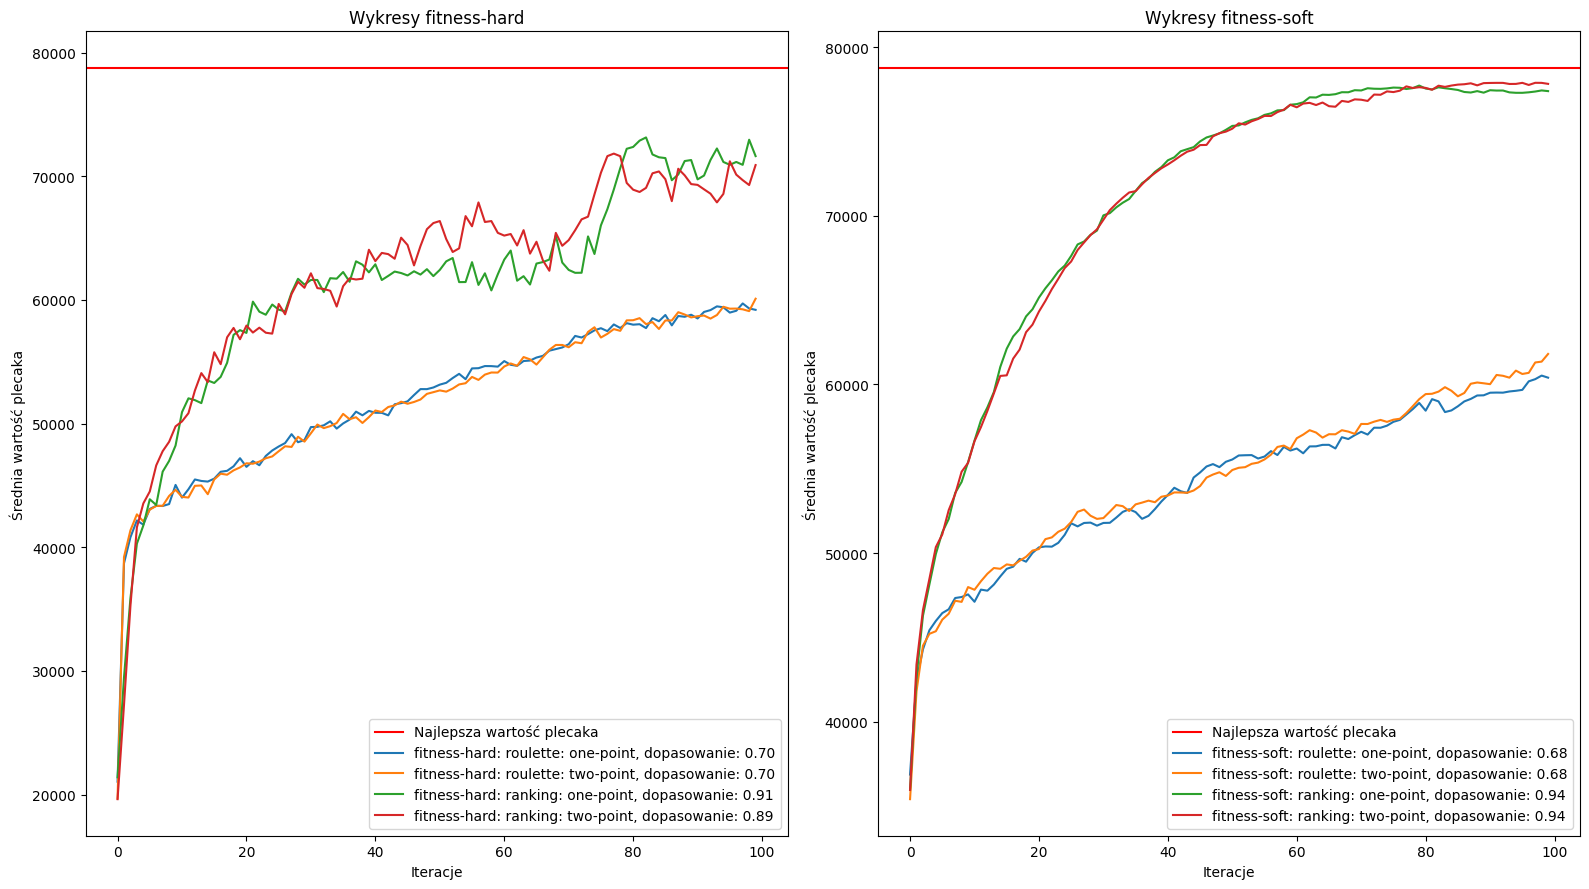

In [ ]:
test = GeneticAlgorithm()
t1 = time.time()

population = 1000
iterations = 100

approximate_solutions1, history1, sc1 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_hard, roulette_select, one_point_cross, mutation, iters=iterations, trueSolution=solution)
t2 = time.time()
print("SOLVING VIA GENETIC PROGRAMMING DONE IN: " + str(t2 - t1) + " s.")
#print(approximate_solutions1)

isEqual = np.array([np.array_equal(solution, approx) for approx in approximate_solutions1])
#print(isEqual)
#results = np.sum(approximate_solutions1 * v, axis=1)
#print(results)
approximate_solutions2, history2, sc2 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_hard, roulette_select, two_point_cross, mutation, iters=iterations, trueSolution=solution)

approximate_solutions3, history3, sc3 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_hard, ranking_select, one_point_cross, mutation, iters=iterations, trueSolution=solution)
approximate_solutions4, history4, sc4 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_hard, ranking_select, two_point_cross, mutation, iters=iterations, trueSolution=solution)

approximate_solutions5, history5, sc5 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_soft, roulette_select, one_point_cross, mutation, iters=iterations, trueSolution=solution)
approximate_solutions6, history6, sc6 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_soft, roulette_select, two_point_cross, mutation, iters=iterations, trueSolution=solution)

approximate_solutions7, history7, sc7 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_soft, ranking_select, one_point_cross, mutation, iters=iterations, trueSolution=solution)
approximate_solutions8, history8, sc8 = test.generateApproximateSolution(n, v, c, C, population, chromosome_func_DKP, fitness_func_soft, ranking_select, two_point_cross, mutation, iters=iterations, trueSolution=solution)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

# Pierwszy wykres (od history1 do history4)
ax1.axhline(y=best_pack_value, color='r', linestyle='-', label='Najlepsza wartość plecaka')
ax1.plot(history1, label=f"fitness-hard: roulette: one-point, dopasowanie: {sc1:.2f}")
ax1.plot(history2, label=f"fitness-hard: roulette: two-point, dopasowanie: {sc2:.2f}")
ax1.plot(history3, label=f"fitness-hard: ranking: one-point, dopasowanie: {sc3:.2f}")
ax1.plot(history4, label=f"fitness-hard: ranking: two-point, dopasowanie: {sc4:.2f}")
ax1.set_title("Wykresy fitness-hard")
ax1.set_xlabel("Iteracje")
ax1.set_ylabel("Średnia wartość plecaka")
ax1.legend()

# Drugi wykres (od history5 do history8)
ax2.axhline(y=best_pack_value, color='r', linestyle='-', label='Najlepsza wartość plecaka')
ax2.plot(history5, label=f"fitness-soft: roulette: one-point, dopasowanie: {sc5:.2f}")
ax2.plot(history6, label=f"fitness-soft: roulette: two-point, dopasowanie: {sc6:.2f}")
ax2.plot(history7, label=f"fitness-soft: ranking: one-point, dopasowanie: {sc7:.2f}")
ax2.plot(history8, label=f"fitness-soft: ranking: two-point, dopasowanie: {sc8:.2f}")
ax2.set_title("Wykresy fitness-soft")
ax2.set_xlabel("Iteracje")
ax2.set_ylabel("Średnia wartość plecaka")
ax2.legend()

plt.tight_layout()
plt.show()